In [1]:
import pandas as pd
import robin_stocks.robinhood as r
import numpy as np

from scipy.special import comb
from itertools import combinations
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor,Pool

import plotly.graph_objects as go
import matplotlib.pyplot as plt

import gc

In [2]:
account = r.login(username='',password='') #Fill in Email/Password

In [3]:
tickerList = ['AAPL','TSLA','NVDA','META','COST','NFLX','AMZN','VOO','SPY']

df = pd.DataFrame(r.get_stock_historicals(tickerList,interval='day',span='5year'))
df = df.drop(['session','interpolated'], axis=1)
df['begins_at'] = pd.to_datetime(df['begins_at']).dt.tz_localize(None)
df = df.astype({'open_price':'float32','close_price':'float32','high_price':'float32','low_price':'float32','volume':'float32'})

#Extra Features
df['DoY'] = df['begins_at'].dt.day + df['begins_at'].dt.month*30
df['MoY'] = df['begins_at'].dt.month
df['year'] = (df['begins_at'].dt.year-1000)/100
df['sin_time_id_day'] = np.sin(2 * np.pi * df['DoY'] / 365) 
df['cos_time_id_day'] = np.cos(2 * np.pi * df['DoY'] / 365)
df['sin_time_id_month'] = np.sin(2 * np.pi * df['MoY'] / 12) 
df['cos_time_id_month'] = np.cos(2 * np.pi * df['MoY'] / 12)

#Target
df['change'] = np.where(
    df['symbol'].shift(-1) == df['symbol'], 
    df['open_price'].shift(-1) - df['close_price'], 
    np.NaN
)
df.dropna(inplace=True)
df['pct_chg'] = df['change'] / df['close_price']

df['symbol'] = df['symbol'].map(dict(zip(tickerList, range(len(tickerList))))) #Vectorize ticker names for models

valid_symbol = df[df['symbol']==tickerList.index('SPY')] 
hist_data = valid_symbol.iloc[len(valid_symbol)//2:] #Validation stock is set to first half SPY data


df = df.drop(hist_data.index,axis=0)

df = df.reset_index()
df['group_id'] = df.index // 100

In [4]:
class CombinatorialPurgedGroupKFold():
    def __init__(self, n_splits = 6, n_test_splits = 2, purge = 1, pctEmbargo = 0.02, **kwargs):
        self.n_splits = n_splits
        self.n_test_splits = n_test_splits
        self.purge = purge
        self.pctEmbargo = pctEmbargo
        
    def split(self, X, y = None, groups = None):
        print("Doing Split")
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
            
        u, ind = np.unique(groups, return_index = True)
        unique_groups = u[np.argsort(ind)]
        n_groups = len(unique_groups)
        group_dict = {}
        for idx in range(len(X)):
            if groups[idx] in group_dict:
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
                
        n_folds = comb(self.n_splits, self.n_test_splits, exact = True)
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
            
        mbrg = int(n_groups * self.pctEmbargo)
        if mbrg < 0:
            raise ValueError(
                "The number of 'embargoed' groups should not be negative")
        
        split_dict = {}
        group_test_size = n_groups // self.n_splits
        for split in range(self.n_splits):
            if split == self.n_splits - 1:
                split_dict[split] = unique_groups[int(split * group_test_size):].tolist()
            else:
                split_dict[split] = unique_groups[int(split * group_test_size):int((split + 1) * group_test_size)].tolist()
        
        for test_splits in combinations(range(self.n_splits), self.n_test_splits):
            test_groups = []
            banned_groups = []
            for split in test_splits:
                test_groups += split_dict[split]
                banned_groups += unique_groups[split_dict[split][0] - self.purge:split_dict[split][0]].tolist()
                banned_groups += unique_groups[split_dict[split][-1] + 1:split_dict[split][-1] + self.purge + mbrg + 1].tolist()
            train_groups = [i for i in unique_groups if (i not in banned_groups) and (i not in test_groups)]

            train_idx = []
            test_idx = []
            for train_group in train_groups:
                train_idx += group_dict[train_group]
            for test_group in test_groups:
                test_idx += group_dict[test_group]
            yield train_idx, test_idx

In [5]:
class CONFIG:
    feature_cols = ["sin_time_id_day", "cos_time_id_day", 'open_price', 'close_price', 'high_price', 'low_price','volume', 'symbol','sin_time_id_month','cos_time_id_month','DoY','MoY','year']
    target_col = 'pct_chg'
    n_splits = len(tickerList)
    n_test_splits = 2

In [6]:
# Custom R2 metric for XGBoost
def r2_xgb(y_true, y_pred):
    r2 = 1 - np.average((y_pred - y_true) ** 2) / (np.average((y_true) ** 2) + 1e-38)
    return -r2
# Custom R2 metric for LightGBM
def r2_lgb(y_true, y_pred):
    r2 = 1 - np.average((y_pred - y_true) ** 2) / (np.average((y_true) ** 2) + 1e-38)
    return 'r2', r2, True
# Custom R2 metric for CatBoost
class r2_cbt(object):
    def get_final_error(self, error, weight,*args):
        return 1 - error 

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w * (target[i] ** 2)
            error_sum += w * ((approx[i] - target[i]) ** 2)

        return error_sum, weight_sum

In [7]:
XGB_Params = {
    'learning_rate': 0.08,
    'objective' : "reg:squarederror",
    'max_depth': 7,
    'n_estimators': 2000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'tree_method' : "hist",
    'device' : "cpu",
    'verbosity' : 1,
    'early_stopping_rounds':100,
    'eval_metric' : r2_xgb,
}
LGBM_Params = {
     "device" : "cpu",
     "objective" : "regression_l2",
     "metrics" : "custom",
     "n_estimators" : 500,
     "max_depth" : 10,
     "num_leaves": 1024,
     "learning_rate" : 0.001,
     "colsample_bytree" : 0.1,
     "min_data_in_leaf" : 10000,
     "subsample" : 0.80,
     "reg_lambda" : 1.25,
     "reg_alpha" : 0.001,
     "verbosity" : -1,
}

CatBoost_Params = {
    'iterations' : 1000, 
    'learning_rate' : 0.05, 
    'task_type' : 'CPU', 
    'loss_function' : 'RMSE', 
    'eval_metric' : r2_cbt(),
}

In [8]:
def train(seed):
    models = []
    kfold = CombinatorialPurgedGroupKFold (CONFIG.n_splits, CONFIG.n_test_splits)
    
    for (ii, (id0, id1)) in enumerate(kfold.split(df, groups = df['group_id'])):
        print(f"Training Split #{ii}")
        modelxgb = XGBRegressor(random_state=seed, **XGB_Params)
        modelgbm= LGBMRegressor(random_state=seed,**LGBM_Params)
        modelcbt = CatBoostRegressor(random_state=seed, **CatBoost_Params) 
        X_train, X_valid = df.loc[id0, CONFIG.feature_cols], df.loc[id1, CONFIG.feature_cols]
        y_train, y_valid = df.loc[id0, CONFIG.target_col], df.loc[id1, CONFIG.target_col]
        print(f"Length of train: {len(X_train)}, Length of valid: {len(X_valid)}")
        modelxgb.fit(X_train, y_train, 
                  eval_set=[(X_valid, y_valid)], 
                  verbose=10)
        modelgbm.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],eval_metric=r2_lgb)
        evalset = Pool(X_valid, y_valid)
        modelcbt.fit(X_train, y_train,
                      eval_set=[evalset], 
                      verbose=10)
        models.append(modelxgb)
        models.append(modelgbm)
        models.append(modelcbt)
        del evalset, X_train, X_valid, y_train, y_valid
        gc.collect()
    return models

In [9]:
def ensemble_predict(models, X):
    predictions = np.zeros((len(X), len(models)))

    for i, model in enumerate(models):
        predictions[:, i] = model.predict(X)

    ensemble_pred = np.mean(predictions, axis=1)
    return ensemble_pred

In [10]:
models = train(7)

Doing Split
Training Split #0
Length of train: 8184, Length of valid: 2200
[10]	validation_0-rmse:0.01987	validation_0-r2_xgb:-0.01829
[20]	validation_0-rmse:0.01982	validation_0-r2_xgb:-0.02376
[30]	validation_0-rmse:0.01978	validation_0-r2_xgb:-0.02705
[40]	validation_0-rmse:0.01975	validation_0-r2_xgb:-0.03063
[50]	validation_0-rmse:0.01974	validation_0-r2_xgb:-0.03158
[60]	validation_0-rmse:0.01972	validation_0-r2_xgb:-0.03312
[70]	validation_0-rmse:0.01972	validation_0-r2_xgb:-0.03350
[80]	validation_0-rmse:0.01972	validation_0-r2_xgb:-0.03356
[90]	validation_0-rmse:0.01971	validation_0-r2_xgb:-0.03401
[100]	validation_0-rmse:0.01970	validation_0-r2_xgb:-0.03481
[110]	validation_0-rmse:0.01970	validation_0-r2_xgb:-0.03504
[120]	validation_0-rmse:0.01970	validation_0-r2_xgb:-0.03513
[130]	validation_0-rmse:0.01969	validation_0-r2_xgb:-0.03573
[140]	validation_0-rmse:0.01969	validation_0-r2_xgb:-0.03602
[150]	validation_0-rmse:0.01968	validation_0-r2_xgb:-0.03688
[160]	validation_0-

In [11]:
X_test = hist_data[CONFIG.feature_cols]
y_test = hist_data[CONFIG.target_col]

ypred = ensemble_predict(models, X_test)

In [12]:
print(f'r2 Score: {r2_score(y_test,ypred)}')

r2 Score: 0.047665652684270476


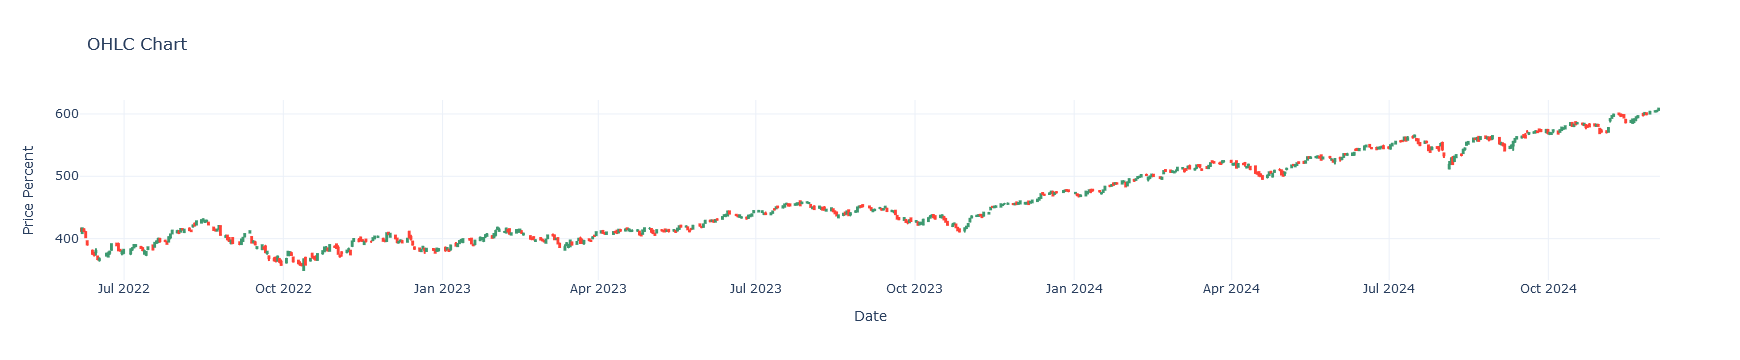

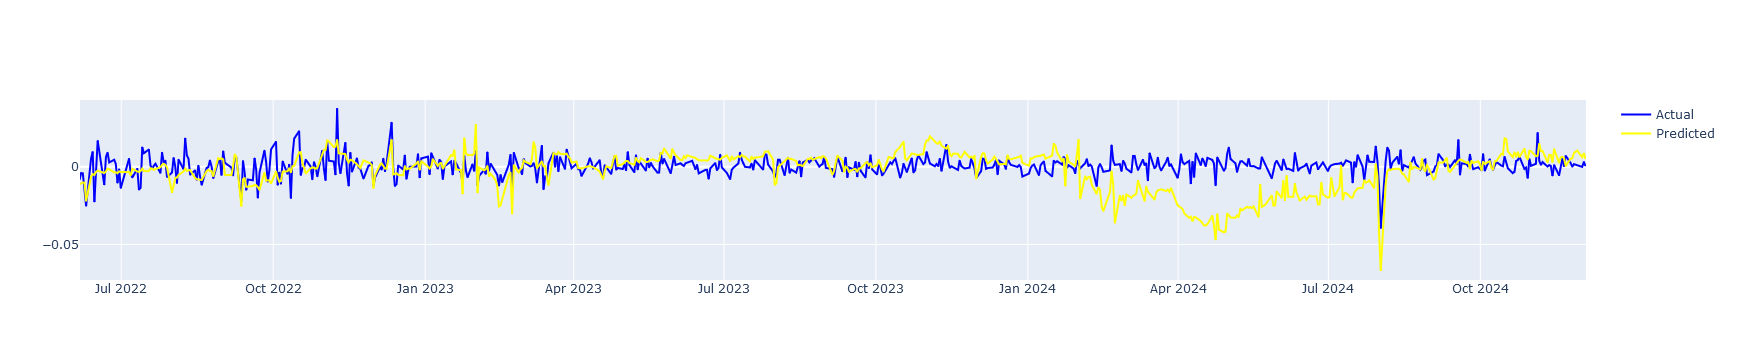

In [18]:
fig = go.Figure()
fig2 = go.Figure()


fig.add_trace(go.Candlestick(

    x=hist_data['begins_at'],
    open=hist_data['open_price'],
    high=hist_data['high_price'],
    low=hist_data['low_price'],
    close=hist_data['close_price'],
    name='OHLC'

))
fig.update_layout(
    title=f"OHLC Chart for GOOGL",
    xaxis_title="Date",
    yaxis_title="Price",
    xaxis_rangeslider_visible=False,
    template="plotly_white"
)

# Overlay predicted values as a line
fig2.add_trace(go.Scatter(
    x=hist_data['begins_at'],
    y=y_test,
    mode='lines',
    name='Actual',
    line=dict(color='blue', width=2)
))

fig2.add_trace(go.Scatter(
    x=hist_data['begins_at'],
    y=ypred*10,                  ## Times 10 here for easier visualization
    mode='lines',
    name='Predicted',
    line=dict(color='yellow', width=2)
))

fig.update_layout(
    title="OHLC Chart ",
    xaxis_title="Date",
    yaxis_title="Price Percent",
    xaxis_rangeslider_visible=False,
    template="plotly_white"
)



# Show plot

fig.show()

fig2.show()


In [14]:
#Get today's data and predict change for each stocks next open:
#Meant to be run while market is still open/before Robinhood adds yesterday's data to .get_stock_historicals() 
#Uses the current quote to fill in for the current day's close_price so its most accurate if run right before market close

ohl = r.get_fundamentals(tickerList)
df1 = pd.DataFrame(ohl,columns=['market_date','open','high','low','volume','symbol'])

df1['market_date'] = pd.to_datetime(df1['market_date']).dt.tz_localize(None)
df1 = df1.rename(columns={'open':'open_price','high':'high_price','low':'low_price'})

df1['close_price'] =  r.get_latest_price(tickerList)

df1 = df1.astype({'open_price':'float32','close_price':'float32',
                  'high_price':'float32','low_price':'float32','volume':'float32'})

df1['symbol'] = df1['symbol'].map(dict(zip(tickerList, range(len(tickerList)))))
df1['DoY'] = df1['market_date'].dt.day + df1['market_date'].dt.month*30
df1['MoY'] = df1['market_date'].dt.month
df1['year'] = (df1['market_date'].dt.year-1000)/100
df1['sin_time_id_day'] = np.sin(2 * np.pi * df1['DoY'] / 365) 
df1['cos_time_id_day'] = np.cos(2 * np.pi * df1['DoY'] / 365)
df1['sin_time_id_month'] = np.sin(2 * np.pi * df1['MoY'] / 12) 
df1['cos_time_id_month'] = np.cos(2 * np.pi * df1['MoY'] / 12)


df1['pred_pct_chg'] = ensemble_predict(models, df1[CONFIG.feature_cols])
df1['predprice'] = df1['close_price']*df1['pred_pct_chg']+df1['close_price']
df1['chg'] = df1['close_price']*df1['pred_pct_chg']
df1['name'] = tickerList

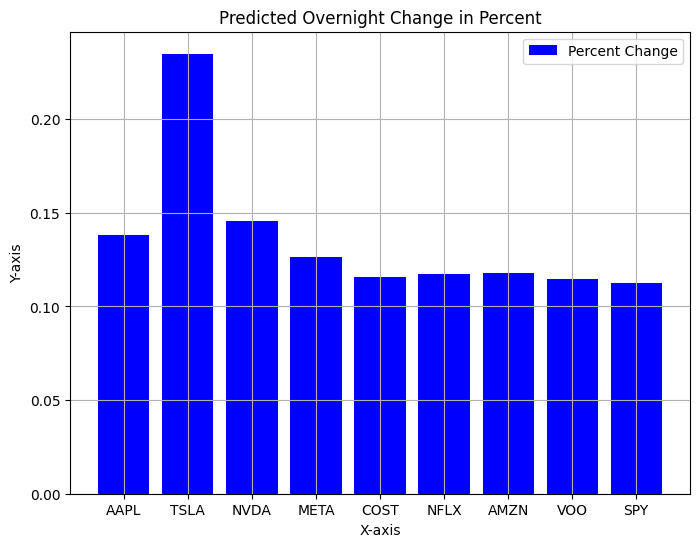

In [15]:
plt.figure(figsize=(8, 6))

plt.bar(df1['name'], df1['pred_pct_chg']*100, label="Percent Change", linewidth=2.5, color='blue')

plt.title("Predicted Overnight Change in Percent")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()

plt.grid(True)
plt.show()

In [16]:
df1

,market_date,open_price,high_price,low_price,volume,symbol,close_price,DoY,MoY,year,sin_time_id_day,cos_time_id_day,sin_time_id_month,cos_time_id_month,pred_pct_chg,predprice,chg,name
0,2024-12-06,242.970001,244.630005,242.080002,36844396.0,0,242.389999,366,12,10.24,0.017213,0.999852,-2.449294e-16,1.0,0.001382,242.725006,0.335007,AAPL
1,2024-12-06,377.470001,389.489990,370.799988,80406776.0,1,391.809998,366,12,10.24,0.017213,0.999852,-2.449294e-16,1.0,0.002349,392.730323,0.920325,TSLA
2,2024-12-06,144.649994,145.699997,141.309998,187140848.0,2,141.999802,366,12,10.24,0.017213,0.999852,-2.449294e-16,1.0,0.001454,142.206199,0.206397,NVDA
3,2024-12-06,609.710022,629.789917,608.530029,16920460.0,3,623.640015,366,12,10.24,0.017213,0.999852,-2.449294e-16,1.0,0.001264,624.428440,0.788425,META
4,2024-12-06,982.599976,997.706787,982.260010,1734966.0,4,992.619995,366,12,10.24,0.017213,0.999852,-2.449294e-16,1.0,0.001155,993.766308,1.146313,COST
5,2024-12-06,915.229980,935.270020,912.710022,2951806.0,5,935.250000,366,12,10.24,0.017213,0.999852,-2.449294e-16,1.0,0.001173,936.346785,1.096785,NFLX
6,2024-12-06,220.809998,227.130005,220.600006,44105816.0,6,226.630005,366,12,10.24,0.017213,0.999852,-2.449294e-16,1.0,0.001181,226.897626,0.267621,AMZN
7,2024-12-06,558.469971,559.960022,558.080017,5128065.0,7,558.799988,366,12,10.24,0.017213,0.999852,-2.449294e-16,1.0,0.001145,559.439626,0.639638,VOO
8,2024-12-06,607.440002,609.059875,607.020020,31152004.0,8,607.590027,366,12,10.24,0.017213,0.999852,-2.449294e-16,1.0,0.001123,608.272368,0.682341,SPY
